In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

2023-06-21 13:03:26.945697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes

# create dataframe containing the genes that passed an initial QC (see Pan et al. 2022) and their corresponding gene label and extract the gene labels
gene_dict_df = pd.read_csv("../0.data-download/data/CRISPR_gene_dictionary.tsv", delimiter='\t')
gene_list = []
for index, row in gene_dict_df.iterrows():
    if row['qc_pass'] == True:
        gene_list.append(row['dependency_column'])

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
print(subset_train_df.shape)
subset_train_df.head(3)

(775, 2862)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,0.430881,0.409231,0.411999,0.667157,0.227795,0.360809,0.495650,0.404166,0.166441,0.776526,...,0.598001,0.451811,0.641335,0.605154,0.543888,0.501539,0.662224,0.626387,0.348650,0.647628
1,0.532213,0.601541,0.539137,0.548927,0.420359,0.648816,0.546755,0.471328,0.599563,0.799985,...,0.601227,0.608215,0.595701,0.682574,0.755678,0.656786,0.682685,0.464491,0.523889,0.685059
2,0.688221,0.499505,0.666826,0.405996,0.504417,0.406611,0.363202,0.707411,1.000000,0.921687,...,0.569760,0.555936,0.632887,0.516597,0.409250,0.472539,0.734322,0.534847,0.421047,0.612980


In [7]:
print(subset_test_df.shape)
subset_test_df.head(3)

(137, 2862)


,AAAS (8086),AAMP (14),AARS1 (16),AARS2 (57505),AASDHPPT (60496),AATF (26574),ABCE1 (6059),ABCF1 (23),ABI1 (10006),ABL1 (25),...,ZNHIT3 (9326),ZNHIT6 (54680),ZNRD2 (10534),ZPR1 (8882),ZRANB1 (54764),ZSWIM6 (57688),ZW10 (9183),ZWILCH (55055),ZWINT (11130),ZZZ3 (26009)
0,0.623792,0.399500,0.431339,0.677779,0.493598,0.449210,0.316313,0.472823,0.647800,0.779713,...,0.618241,0.585388,0.554390,0.665885,0.542091,0.345852,0.696704,0.667496,0.164927,0.436068
1,0.475233,0.578376,0.502013,0.762832,0.674328,0.385524,0.619403,0.446919,0.358274,0.854183,...,0.574641,0.515366,0.664194,0.492178,0.751965,0.662451,0.585085,0.755518,0.697598,0.780292
2,0.634688,0.439362,0.314825,0.712739,0.525987,0.553006,0.654827,0.563606,0.720128,0.733189,...,0.297408,0.407610,0.549608,0.045558,0.324679,0.495215,0.531524,0.506229,0.412075,0.581211


In [8]:
encoder_architecture = []
decoder_architecture = []

In [9]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=70,
    batch_size=16,
    encoder_batch_norm=True,
    epochs=805, 
    learning_rate=0.0001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=3,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

2023-06-21 13:03:33.038203: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/805
49/49 [==============================] - 6s 113ms/step - loss: 1358.2208 - recon: 1256.5248 - kl: 101.6963 - val_loss: 1112.0460 - val_recon: 1076.1014 - val_kl: 35.9446
Epoch 2/805
49/49 [==============================] - 5s 108ms/step - loss: 1176.2084 - recon: 1078.1250 - kl: 98.0835 - val_loss: 949.9850 - val_recon: 912.1734 - val_kl: 37.8117
Epoch 3/805
49/49 [==============================] - 5s 113ms/step - loss: 1020.0483 - recon: 923.6176 - kl: 96.4308 - val_loss: 795.1184 - val_recon: 732.7521 - val_kl: 62.3663
Epoch 4/805
49/49 [==============================] - 5s 106ms/step - loss: 879.4370 - recon: 784.0501 - kl: 95.3869 - val_loss: 833.9913 - val_recon: 736.8276 - val_kl: 97.1637
Epoch 5/805
49/49 [==============================] - 5s 106ms/step - loss: 772.1980 - recon: 677.0319 - kl: 95.1662 - val_loss: 614.4387 - val_recon: 473.2511 - val_kl: 141.1877
Epoch 6/805
49/49 [==============================] - 5s 92ms/step - loss: 680.9113 - recon: 585.8799 - kl:

In [11]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [12]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

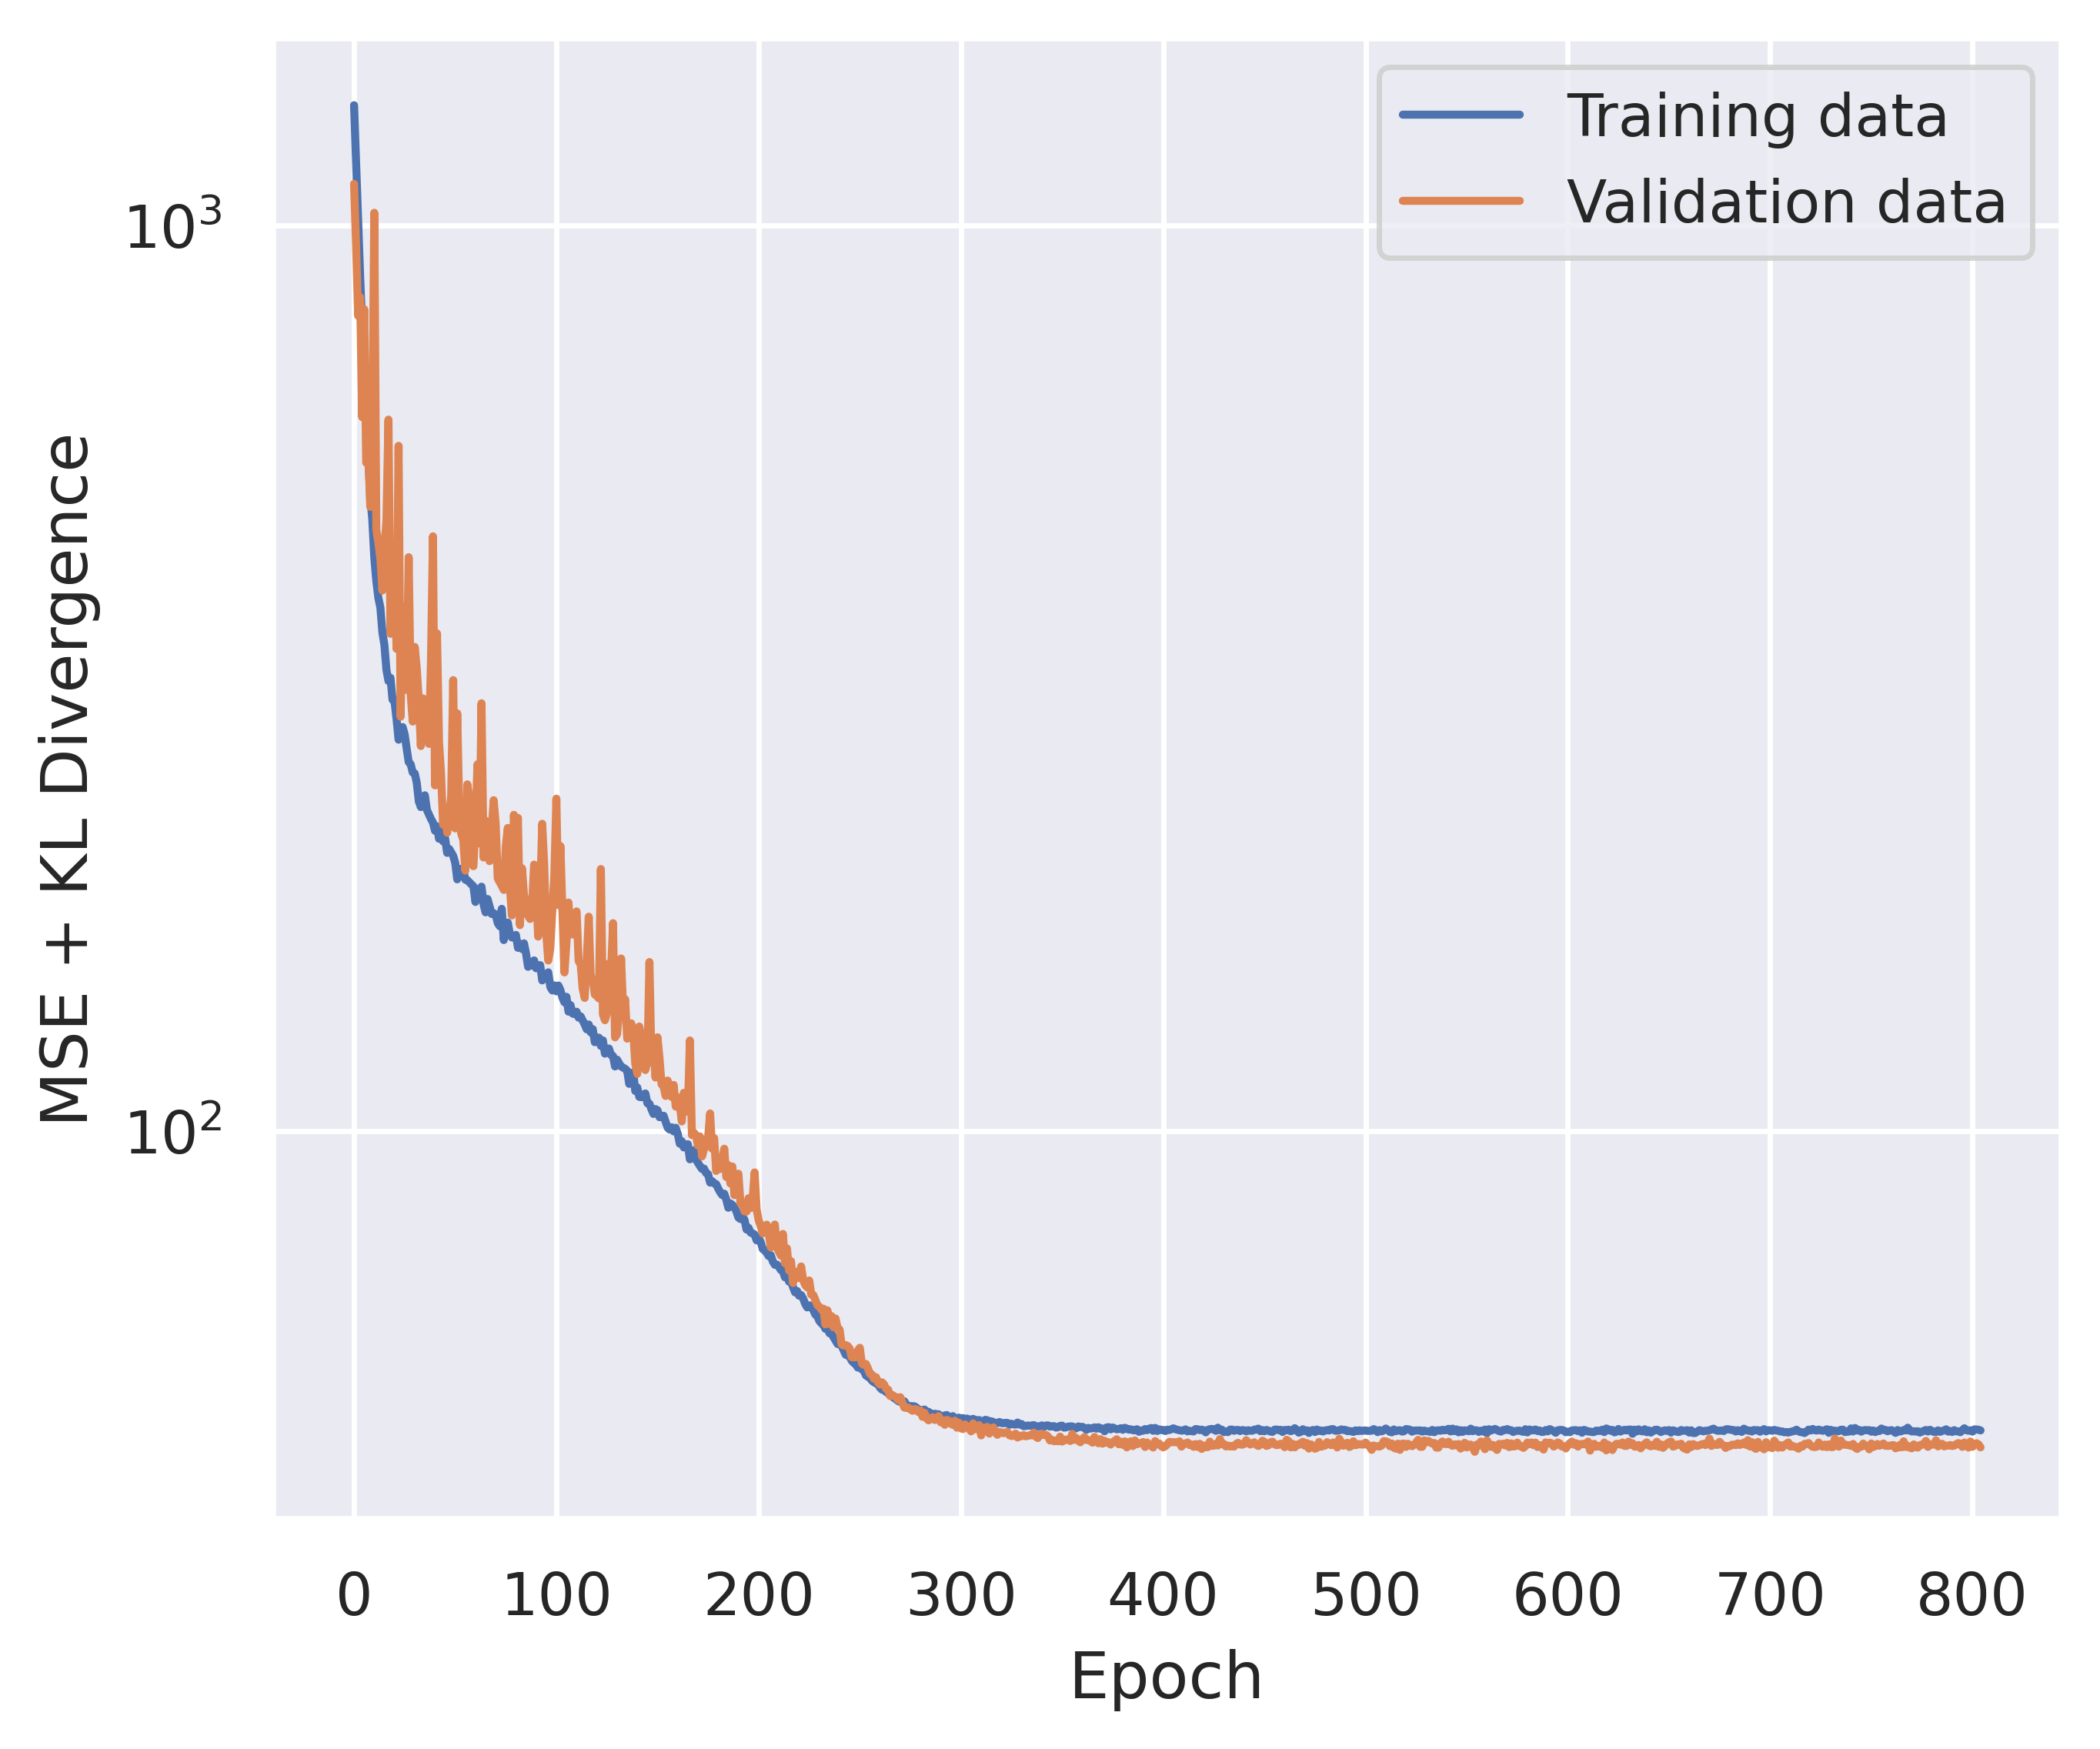

In [13]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [14]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [15]:
data_dir = "../0.data-download/data/"
model_df, effect_df = load_data(data_dir, adult_or_pediatric="all")

In [16]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [17]:
# create a data frame of both test and train gene effect data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)

metadata_df_dir = pathlib.Path("../0.data-download/data/metadata_df.csv")
metadata.to_csv(metadata_df_dir, index=False)
metadata


,ModelID,AgeCategory,Sex,train_or_test
0,ACH-001098,Adult,Female,train
1,ACH-000191,Adult,Female,train
2,ACH-001664,Adult,Male,train
3,ACH-002015,Adult,Female,train
4,ACH-000550,Adult,Male,train
...,...,...,...,...
907,ACH-000775,Adult,Female,test
908,ACH-000155,Adult,Male,test
909,ACH-000704,Adult,Female,test
910,ACH-002042,Adult,Female,test


In [18]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the Model IDs added back in
extracted_col = metadata['ModelID']

latent_df.insert(0, 'ModelID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

29/29 [==============================] - 1s 26ms/step


,ModelID,0,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
0,ACH-001098,0.667955,-0.710161,-1.288565,-0.178892,-0.122788,1.070932,0.008247,-0.141455,-0.632038,...,0.369377,-1.935832,-0.185997,-0.659780,-0.107567,-0.363950,0.848581,1.179960,-0.050720,-0.643959
1,ACH-000191,0.455197,0.192505,0.139463,-1.966845,-0.043970,0.620343,-1.653840,-0.842657,1.978976,...,1.325327,-0.611144,0.467527,1.300587,-0.654522,-0.373168,-0.675906,-0.372202,0.234228,0.253179
2,ACH-001664,1.316046,-2.548527,0.191967,-0.328286,1.294379,-0.359970,-1.311745,-1.135129,0.142615,...,-1.046155,-0.576074,-0.278178,1.916314,0.796305,-2.150311,1.827619,2.006124,-0.261891,-0.423953
3,ACH-002015,1.303491,-0.112393,-1.241137,1.999312,-0.044983,-0.159562,1.581147,1.079809,0.436217,...,-1.876318,0.429358,-1.364914,0.727810,-0.055593,2.557539,-1.266545,0.077816,-0.634921,-0.060857
4,ACH-000550,1.388631,0.263337,1.232808,1.414153,1.681742,-0.795968,1.598389,-0.533899,-1.410749,...,-1.088517,0.298394,0.209960,-0.031674,0.058155,-1.278273,1.686000,0.324850,-1.138205,-0.743968


In [19]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.000101,-0.037931,-0.036681,-0.027198,0.043804,-0.037495,0.036276,0.006421,0.008637,0.025438,...,0.004682,0.010450,0.000324,0.004844,0.024128,0.008368,-0.008839,0.006769,0.035937,0.016593
1,-0.011206,0.023624,-0.017611,0.022335,0.034596,-0.042634,0.009411,-0.013815,-0.013696,-0.021911,...,0.005329,-0.037666,-0.012470,-0.003478,0.015595,-0.011644,-0.014867,0.001246,-0.020725,-0.021174
2,-0.014978,-0.039624,-0.023902,0.011588,0.001689,0.027187,0.026177,-0.050210,-0.013767,-0.042664,...,0.023402,-0.013334,-0.049046,0.026138,0.000754,0.013036,0.007455,0.017787,-0.017051,0.007649
3,-0.033118,-0.011848,-0.057877,0.009614,0.018117,0.062050,0.055039,-0.036307,-0.006781,-0.032209,...,0.004676,-0.052899,-0.028335,-0.000572,-0.002464,0.004491,-0.004105,-0.045096,-0.013774,-0.026740
4,-0.015627,0.019984,-0.023834,0.060897,-0.001235,0.035667,-0.020289,0.009512,-0.015328,0.007719,...,0.014733,-0.035435,-0.046767,0.029246,0.017557,0.022444,0.011002,-0.009545,-0.030216,-0.047760


In [20]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,AAAS,0.000101,-0.037931,-0.036681,-0.027198,0.043804,-0.037495,0.036276,0.006421,0.008637,...,0.004682,0.010450,0.000324,0.004844,0.024128,0.008368,-0.008839,0.006769,0.035937,0.016593
1,AAMP,-0.011206,0.023624,-0.017611,0.022335,0.034596,-0.042634,0.009411,-0.013815,-0.013696,...,0.005329,-0.037666,-0.012470,-0.003478,0.015595,-0.011644,-0.014867,0.001246,-0.020725,-0.021174
2,AARS1,-0.014978,-0.039624,-0.023902,0.011588,0.001689,0.027187,0.026177,-0.050210,-0.013767,...,0.023402,-0.013334,-0.049046,0.026138,0.000754,0.013036,0.007455,0.017787,-0.017051,0.007649
3,AARS2,-0.033118,-0.011848,-0.057877,0.009614,0.018117,0.062050,0.055039,-0.036307,-0.006781,...,0.004676,-0.052899,-0.028335,-0.000572,-0.002464,0.004491,-0.004105,-0.045096,-0.013774,-0.026740
4,AASDHPPT,-0.015627,0.019984,-0.023834,0.060897,-0.001235,0.035667,-0.020289,0.009512,-0.015328,...,0.014733,-0.035435,-0.046767,0.029246,0.017557,0.022444,0.011002,-0.009545,-0.030216,-0.047760
